## Boundary Map

Load EPA_CWS_V1 shape file. Then, print the coordinate type as well as information of the types of gemoetry in the dataset as well as the number of features. Display a rough map of the gemoetries as well. This is all used to get a grasp of what is all contained in this set.


Coordinate Reference System (CRS):
EPSG:3857

Geometry Type: ['Polygon' 'MultiPolygon']
Number of features: 44415


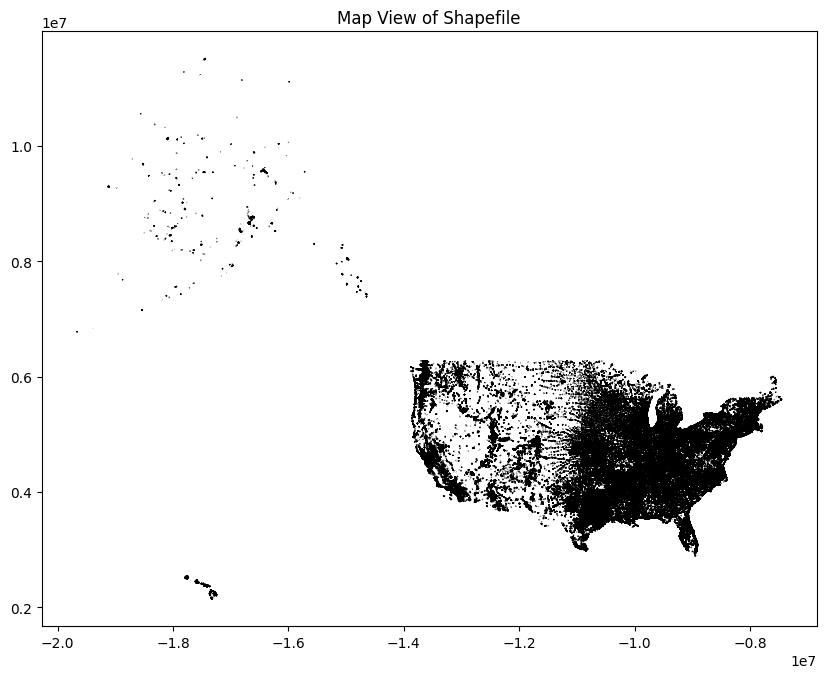

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os

shapefile_dir = "./BoundaryOutputData"
shapefile_name = "EPA_CWS_V1.shp"
shapefile_path = os.path.join(shapefile_dir, shapefile_name)

gdf = gpd.read_file(shapefile_path)

print("\nCoordinate Reference System (CRS):")
print(gdf.crs)

# Display different geometry types and number of features
print(f"\nGeometry Type: {gdf.geom_type.unique()}")
print(f"Number of features: {len(gdf)}")

# Plot the geometry
gdf.plot(figsize=(10, 8), edgecolor='black')
plt.title("Map View of Shapefile")
plt.show()

Load the SDWA violation enforcement csv file. Group violations by PWSID to get a count of violations by PWSID. Then, join onto gdf data to add violation_count field for map purposes.

In [6]:
from matplotlib import pyplot as plt
from sqlalchemy import create_engine, text
import pandas as pd
import os
from dotenv import load_dotenv

load_dotenv()

viol = pd.read_csv(f'{os.getenv("LOCAL_PROJECT_DIR")}/public-analytics/EPA_Data/SDWA_VIOLATIONS_ENFORCEMENT.csv',
                   low_memory=False)

violcount = viol.groupby("PWSID").agg(
    violation_count=("PWSID", "count")
).reset_index()

gdf_viol = pd.merge(gdf, violcount, on="PWSID", how="left", indicator=True)
gdf_viol = gdf_viol.drop(columns=['_merge'])
gdf_viol

,PWSID,State,PWS_Name,Primacy_Ag,Pop_Cat_5,Population,Service_Co,Method,Service_Ar,Symbology_,...,Secondary_,Secondary1,Detailed_F,Date_Creat,Date_Modif,Verifica_2,Shape__Are,Shape__Len,geometry,violation_count
0,010106001,None,Mashantucket Pequot Water System,EPA Region 1,"10,001-100,000",37807,119,Random Forest,Residential Area,MODELED,...,None,None,https://echo.epa.gov/detailed-facility-report?...,2024/06/06,0000/00/00,0000/00/00,9.721703e+06,20361.153082,"POLYGON ((-7998318.749 5068333.946, -7998328.5...",222.0
1,040000002,None,POARCH CREEK UTILITIES - WEST,EPA Region 4,"3,301-10,000",5900,300,Random Forest,Recreation Area,MODELED,...,None,None,https://echo.epa.gov/detailed-facility-report?...,2024/06/06,0000/00/00,0000/00/00,2.243523e+06,13118.771112,"MULTIPOLYGON (((-9746746.551 3645642.731, -974...",6.0
2,041200001,None,SEMINOLE - BRIGHTON RESERVATION,EPA Region 4,"3,301-10,000",6538,200,Random Forest,Residential Area,MODELED,...,None,None,https://echo.epa.gov/detailed-facility-report?...,2024/06/06,0000/00/00,0000/00/00,8.099061e+05,6603.773222,"MULTIPOLYGON (((-9024703.732 3134795.213, -902...",40.0
3,041200002,None,SEMINOLE - BIG CYPRESS,EPA Region 4,"501-3,300",900,300,Random Forest,Residential Area,MODELED,...,None,None,https://echo.epa.gov/detailed-facility-report?...,2024/06/06,0000/00/00,0000/00/00,3.401707e+06,9906.723802,"POLYGON ((-9014440.07 3037556.488, -9014451.09...",17.0
4,041200003,None,SEMINOLE UTILITIES HOLLYWOOD,EPA Region 4,"501-3,300",2709,959,Random Forest,Mobile Home Park,MODELED,...,None,None,https://echo.epa.gov/detailed-facility-report?...,2024/06/06,0000/00/00,0000/00/00,9.235193e+04,1772.861183,"MULTIPOLYGON (((-8929850.033 3003672.296, -892...",42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44410,NH1282010,NH,MOUNTAIN VIEW APTS,New Hampshire,<=500,100,40,State,Residential Area,STATE,...,None,None,https://echo.epa.gov/detailed-facility-report?...,0000/00/00,0000/00/00,0000/00/00,1.589767e+05,2350.497066,"POLYGON ((-7955728.948 5390440.082, -7955685.2...",185.0
44411,NH0342060,NH,MT PROSPECT ACADEMY/CAMPTON,New Hampshire,<=500,32,1,State,Other Residential,STATE,...,None,None,https://echo.epa.gov/detailed-facility-report?...,0000/00/00,0000/00/00,0000/00/00,1.248212e+05,2423.666573,"POLYGON ((-7975912.396 5442846.853, -7975774.5...",167.0
44412,NH0363010,NH,COUNTRY LANE MANOR,New Hampshire,<=500,85,34,State,Mobile Home Park - Principal Residence,STATE,...,None,None,https://echo.epa.gov/detailed-facility-report?...,0000/00/00,0000/00/00,0000/00/00,9.758318e+04,1194.409012,"POLYGON ((-7943929.226 5323247.313, -7944021.4...",64.0
44413,NH1463010,NH,BROOKWOOD PARK,New Hampshire,<=500,50,20,State,Subdivision,STATE,...,None,None,https://echo.epa.gov/detailed-facility-report?...,0000/00/00,0000/00/00,0000/00/00,1.004568e+05,1515.198832,"POLYGON ((-7921965.824 5458903.209, -7921874.1...",146.0


Create map using folium. Uses geometries to display boundary map. The first code cell creates the map, and the second one uses IPython to display the interactive map. The map also saves as an html file with the code. The map has PWSID, State, PWS Name, population served, and violation count.

In [9]:
from IPython.display import display
import folium

gdf_viol = gdf_viol.to_crs(epsg=4326)
gdf_viol["geometry"] = gdf_viol["geometry"].simplify(0.001)

gdf_viol = gdf_viol.copy()

# Convert all datetime columns to string format
for col in gdf_viol.columns:
    if gdf_viol[col].dtype == 'datetime64[ns, UTC]':
        gdf_viol[col] = gdf_viol[col].astype(str)

geojson_data = gdf_viol.to_json()
center3 = [gdf_viol.geometry.centroid.y.mean(), gdf_viol.geometry.centroid.x.mean()] \
 \
# Create the map
m3 = folium.Map(location=center3, zoom_start=10, tiles="cartodb positron")

# Add GeoJSON layer with hover tooltips
folium.GeoJson(
    geojson_data,
    name="Boundary Map",
    tooltip=folium.GeoJsonTooltip(
        fields=["PWSID", "State", "PWS_Name", "Population", "violation_count"],
        aliases=["PWSID", "State", "PWS Name", "Population Served", "Violation Count"],
        localize=True
    ),
    style_function=lambda feature: {
        "color": "black",
        "weight": 2,
        "fillOpacity": 0.3,
        "fillColor": "gray"
    }
).add_to(m3)

/var/folders/q9/xcn47g_x4td5fqk2lzdcvxs80000gn/T/ipykernel_49136/2218351397.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center3 = [gdf_viol.geometry.centroid.y.mean(), gdf_viol.geometry.centroid.x.mean()] \


In [10]:
from IPython.display import IFrame

# Save the map to an HTML file
map3_filename = "gray_boundary_waterly_map.html"
m3.save(map3_filename)

# Display the boundary map
IFrame(map3_filename, width=800, height=600)